# IGMC with Movielens
- 일단 가장 먼저 movielens에 젤 기초적인 gnn하는거부터 다시 체크하기 : 이제 파이토치를 어느정도 이해하고 있으므로 다를 것
- task가 무엇인지, 파라미터가 어떻게 되는지, link는 어떻게 구성하는지, pyg 객체로 되는경우 karate에서 썼던 시각화 코드 될지

## Recommend System based IGMC
- dataset : movielens
- reference : https://medium.com/stanford-cs224w/graph-neural-network-based-movie-recommender-system-5876b9686df3
- after-report : https://velog.io/@seojeongbin/IGMC-Inductive-Graph-based-Matrix-Completion


### 1. 데이터 확인 및 전처리(pivot)
- 평점 분포, 데이터 개수, 결측치 파악 등..
- **기존 df에서 pivot 해주어야함**

In [7]:
import pandas as pd
from matplotlib import pyplot as plt    

# Import torch packages
import torch
from torch.nn import Linear
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.utils import data

# Import PyG packages
import torch_geometric as pyg
import torch_geometric.data as pyg_data
from torch_geometric.typing import Adj, OptTensor
import torch_sparse
from torch_geometric.data import DataLoader
from torch_geometric.nn import RGCNConv
from torch_geometric.utils import dropout_adj


In [2]:
path = r'C:\Users\SeoJeongBin\Desktop\Code\Recommendation\data\movielens'
df_ratings = pd.read_csv(path+'/ratings.csv')
df_movies = pd.read_csv(path+'/movies.csv')
# print(df_ratings.head(3))
# print(df_movies.head(3))
merged = pd.merge(df_ratings, df_movies, on = 'movieId', how = 'left')
merged

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


C:\Users\SeoJeongBin\AppData\Local\Temp\ipykernel_17796\3401854971.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


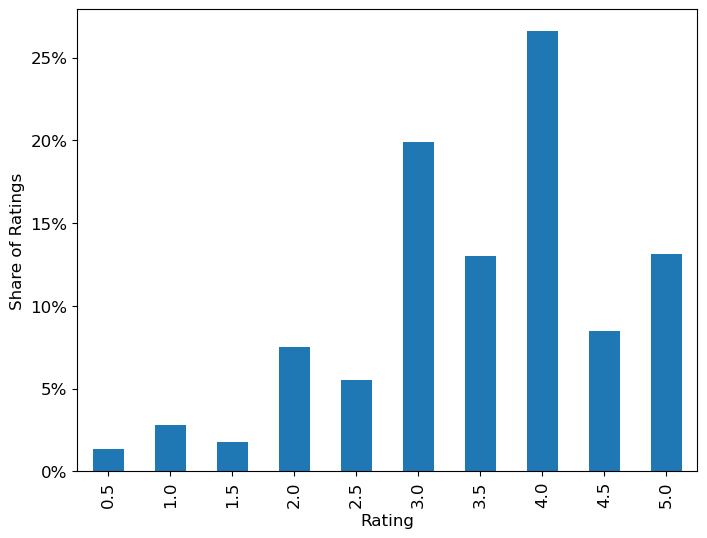

In [3]:
# 평점 분포 파악

fig = plt.figure()
ax = df_ratings.rating.value_counts(True).sort_index().plot.bar(figsize=(8,6))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Share of Ratings', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig('./Ratings_distribution.png')


In [4]:
# df 형태바꿔야됨. 코드로는 한줄로 쉽게 구현가능
R = pd.pivot_table(data=merged, index='userId', columns='title', values='rating')
R.tail(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN
609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
610,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,...,NaN,4.0,3.5,3.0,NaN,NaN,2.0,1.5,NaN,NaN


=> 위의 데이터프레임을 다음과 같은 그림으로 표현할 수 있음
- ![pic](./pic.png)


### Model Build

In [13]:
from torch_geometric.nn import RGCNConv

class IGMC(torch.nn.Module):
    def __init__(self):
        super(IGMC, self).__init__()
        self.rel_graph_convs = torch.nn.ModuleList() # 빈 리스트 정의느낌
        # R-GCN 방식으로 message passing 하는경우가 좀 독특한듯? 그리고 정해져있는 느낌
        # in channels 는 feature가 아니라 node 수인듯(불확실함..아닌데 확실히 임베딩된 차원수일거다. igmc개념 다시 살펴보기). 그리고 out channel 은 하이퍼파라미터고, 이후 층은 인풋 아웃풋이 같은느낌
        # 여기 파라미터들은 ㄹㅇ 하나도 모르겠음
        self.rel_graph_convs.append(RGCNConv(in_channels=4, out_channels=32, num_relations=5, num_bases=4))
        self.rel_graph_convs.append(RGCNConv(in_channels=32, out_channels=32, num_relations=5, num_bases=4))
        self.rel_graph_convs.append(RGCNConv(in_channels=32, out_channels=32, num_relations=5, num_bases=4))
        self.rel_graph_convs.append(RGCNConv(in_channels=32, out_channels=32, num_relations=5, num_bases=4))
        self.linear_layer1 = Linear(256, 128)
        self.linear_layer2 = Linear(128, 1)
        
    def reset_parameters(self):
        self.linear_layer1.reset_parameters()
        self.linear_layer2.reset_parameters()
        for i in self.rel_grpah_convs:
            i.reset_parameters()
            
    def forward(self, data):
        # 1. drop out layer : 랜덤으로 edge 제거 (avoid overfitting)
        num_nodes = len(data.x)
        edge_index_dr, edge_type_dr = dropout_adj(data.edge_index, data.edge_type,\
                                p=0.2, num_nodes=num_nodes, training=self.training)

        out = data.x
        h = []
        # 2. subgraph의 각 node extract 하기
        for conv in self.rel_graph_convs:
            # message passing layer
            out = conv(out, edge_index_dr, edge_type_dr)
            # activated func
            out = torch.tanh(out)
            print(out.shape)
            h.append(out)
        # h가 final한 노드의 임베드라고 함
        h = torch.cat(h, 1) # torch.cat : concat임 1은 가로로붙인다는거
        h = [h[data.x[:, 0] == True], h[data.x[:, 1] == True]] # 이게 user, item concat 느낌
        g = torch.cat(h, 1) # g는 graph 레벨 features 
        out = self.linear_layer1(g)
        out = F.relu(out)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.linear_layer2(out)
        out = out[:,0]
        return out
    
model = IGMC()

### Dataset => 그냥쓰는게 아니라 subgraph로 추출하는 과정이 필요
- 이 부분은 저자의 논문 깃허브를 refer함
- 이 부분때문에 사실상 프로젝트에서 쓰기힘들듯 ㅜㅜ
- 이거땜에 돌릴수도 없다 ㅠㅠ

In [ ]:
'''
(u_features, v_features, adj_train, train_labels, train_u_indices, train_v_indices, val_labels, 
val_u_indices, val_v_indices, test_labels, test_u_indices, test_v_indices, class_values
) = load_official_trainvaltest_split('ml_100k', testing=True)
'''

In [ ]:
'''
train_dataset = eval('MyDynamicDataset')(root='data/ml_100k/testmode/train', A=adj_train, 
    links=(train_u_indices, train_v_indices), labels=train_labels, h=1, sample_ratio=1.0, 
    max_nodes_per_hop=200, u_features=None, v_features=None, class_values=class_values)
test_dataset = eval('MyDataset')(root='data/ml_100k/testmode/test', A=adj_train, 
    links=(test_u_indices, test_v_indices), labels=test_labels, h=1, sample_ratio=1.0, 
    max_nodes_per_hop=200, u_features=None, v_features=None, class_values=class_values)

len(train_dataset), len(test_dataset)
'''

### Training

In [ ]:
LR = 1e-3
EPOCHS = 3
BATCH_SIZE = 50
LR_DECAY_STEP = 20
LR_DECAY_VALUE = 10

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2)

model.to(device)
model.reset_parameters()
opt = Adam(model.parameters(), lr=LR, weight_decay=0)

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss_all = 0
    for train_batch in train_loader:
        opt.zero_grad()
        train_batch = train_batch.to(device)
        y_pred = model(train_batch) # 이게 forward(self, x) 부분이 되는것임!
        y_true = train_batch.y
        train_loss = F.mse_loss(y_pred, y_true)
        train_loss.backward()
        train_loss_all += train_loss.item() * train_batch.num_graphs
        opt.step()
    train_loss_all /= len(train_loader.dataset)

    if epoch % LR_DECAY_STEP == 0:
        for param_group in opt.param_groups:
            param_group['lr'] = param_group['lr'] / LR_DECAY_VALUE
    print('epoch', epoch,'; train loss', train_loss_all)

model.to(device)
model.eval()
test_loss = 0
for test_batch in test_loader:
    test_batch = test_batch.to(device)
    with torch.no_grad():
        y_pred = model(test_batch)
    y_true = test_batch.y
    test_loss += F.mse_loss(y_pred, y_true, reduction='sum')
mse_loss = test_loss.item() / len(test_loader.dataset)

print('test loss', mse_loss)